# 03 — Model Evaluation, Error Analysis & Reporting
**Author:** Joe Todaro

This notebook finalizes the modeling phase by:
- Loading the **final model** and **test predictions** produced in `02_model_pipeline.ipynb`
- Computing **residual analysis** and **fairness-style slices** (by station, DOW, holiday)
- Performing a **rolling backtest** to validate temporal stability
- Producing **stakeholder-ready KPIs** and exporting CSVs to `../data/processed/`


## 1) Setup & Inputs

In [1]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import joblib

plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['axes.grid']=True

DATA_INTERIM = '../data/interim'
DATA_PROCESSED = '../data/processed'
P_SD = f'{DATA_INTERIM}/station_day.csv'
P_PRED = f'{DATA_PROCESSED}/predictions_test.csv'

# Find a previously saved final model artifact
model_art = None
for f in os.listdir(DATA_PROCESSED):
    if f.startswith('final_model_') and f.endswith('.joblib'):
        model_art = os.path.join(DATA_PROCESSED, f)
        break

assert os.path.exists(P_SD), f'Missing: {P_SD}'
assert os.path.exists(P_PRED), f'Missing: {P_PRED}. Run 02_model_pipeline.ipynb first.'
assert model_art is not None, "No final_model_*.joblib found in ../data/processed. Run 02_model_pipeline.ipynb first."

print('Using:'); print('  station_day ->', P_SD); print('  predictions ->', P_PRED); print('  model ->', model_art)

sd = pd.read_csv(P_SD, low_memory=False)
sd['date'] = pd.to_datetime(sd['date'], errors='coerce')
sd = sd.dropna(subset=['date'])

pred = pd.read_csv(P_PRED, low_memory=False)
pred['date'] = pd.to_datetime(pred['date'], errors='coerce')

final_model = joblib.load(model_art)
model_name = os.path.basename(model_art).replace('final_model_','').replace('.joblib','')
print('Loaded final model:', model_name)

Using:
  station_day -> ../data/interim/station_day.csv
  predictions -> ../data/processed/predictions_test.csv
  model -> ../data/processed\final_model_RandomForest.joblib
Loaded final model: RandomForest


## 2) Join Predictions with Calendar Context

In [2]:
# Join on date+station to add holiday/DOW flags for slicing errors
j = pred.merge(sd[['date','station','is_holiday','dow','is_weekend']].drop_duplicates(),
               on=['date','station'], how='left')

j['error'] = j['predicted'] - j['ridership']
j['abs_error'] = j['error'].abs()

print('Joined shape:', j.shape)
display(j.head())

# Overall metrics on test predictions
def mae(y_true, y_pred): return np.mean(np.abs(y_true - y_pred))
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def r2(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    return 1 - ss_res/ss_tot if ss_tot != 0 else np.nan

overall = {
    'MAE': mae(j['ridership'], j['predicted']),
    'RMSE': rmse(j['ridership'], j['predicted']),
    'R2': r2(j['ridership'], j['predicted'])
}
print('Overall test metrics:', overall)

Joined shape: (2461, 9)


,date,station,ridership,predicted,is_holiday,dow,is_weekend,error,abs_error
0,2024-05-02,1 Av (L),47,424.8200,0,3,0,377.8200,377.8200
1,2024-05-07,1 Av (L),1309,345.9800,0,1,0,-963.0200,963.0200
2,2024-05-10,1 Av (L),161,264.8750,0,4,0,103.8750,103.8750
3,2024-05-14,1 Av (L),112,553.6250,0,1,0,441.6250,441.6250
4,2024-05-16,1 Av (L),739,343.1825,0,3,0,-395.8175,395.8175


Overall test metrics: {'MAE': 144.39313795205203, 'RMSE': 390.16496073878795, 'R2': 0.250696285677214}


## 3) Residual Diagnostics

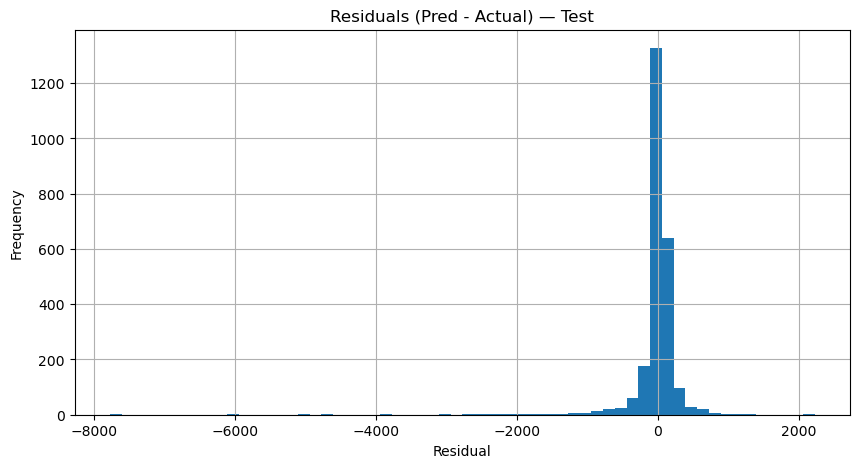

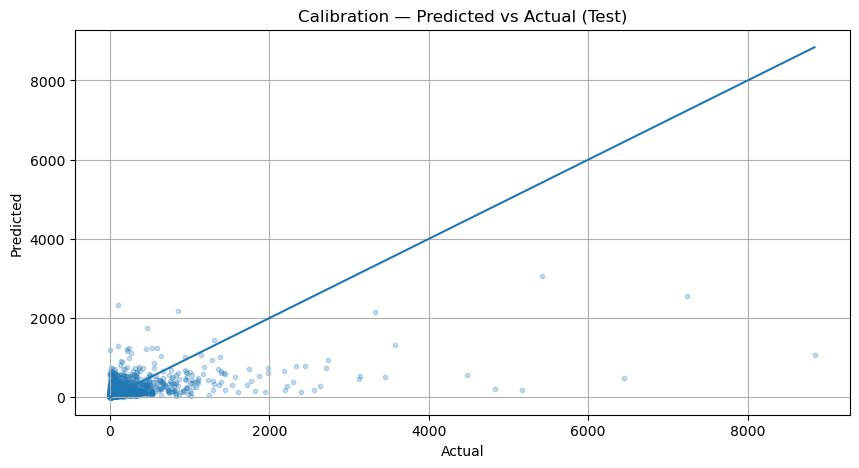

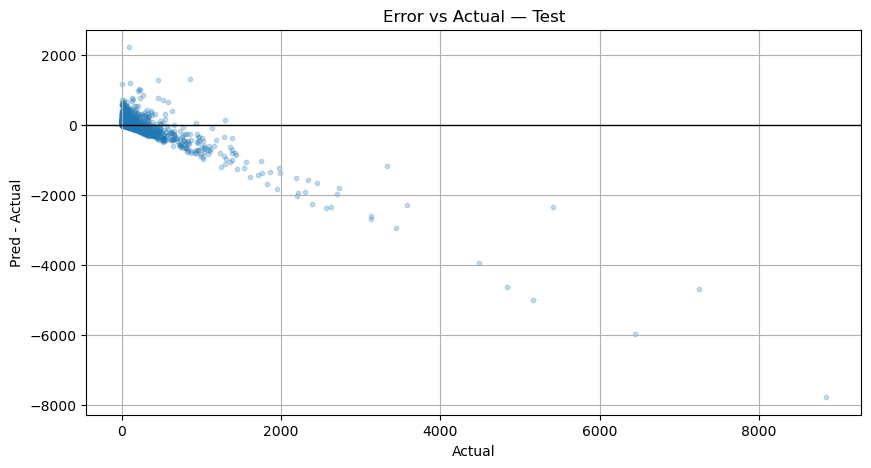

In [3]:
# Residual histogram
fig, ax = plt.subplots()
ax.hist(j['error'], bins=60)
ax.set_title('Residuals (Pred - Actual) — Test'); ax.set_xlabel('Residual'); ax.set_ylabel('Frequency')
plt.show()

# Actual vs Predicted scatter (calibration)
fig, ax = plt.subplots()
ax.scatter(j['ridership'], j['predicted'], s=10, alpha=0.25)
lim = max(j['ridership'].max(), j['predicted'].max())
ax.plot([0,lim],[0,lim])
ax.set_title('Calibration — Predicted vs Actual (Test)'); ax.set_xlabel('Actual'); ax.set_ylabel('Predicted')
plt.show()

# Error vs Actual (heteroscedasticity check)
fig, ax = plt.subplots()
ax.scatter(j['ridership'], j['error'], s=10, alpha=0.25)
ax.axhline(0, color='k', lw=1)
ax.set_title('Error vs Actual — Test'); ax.set_xlabel('Actual'); ax.set_ylabel('Pred - Actual')
plt.show()

## 4) Slice Analysis (Station, DOW, Holiday)

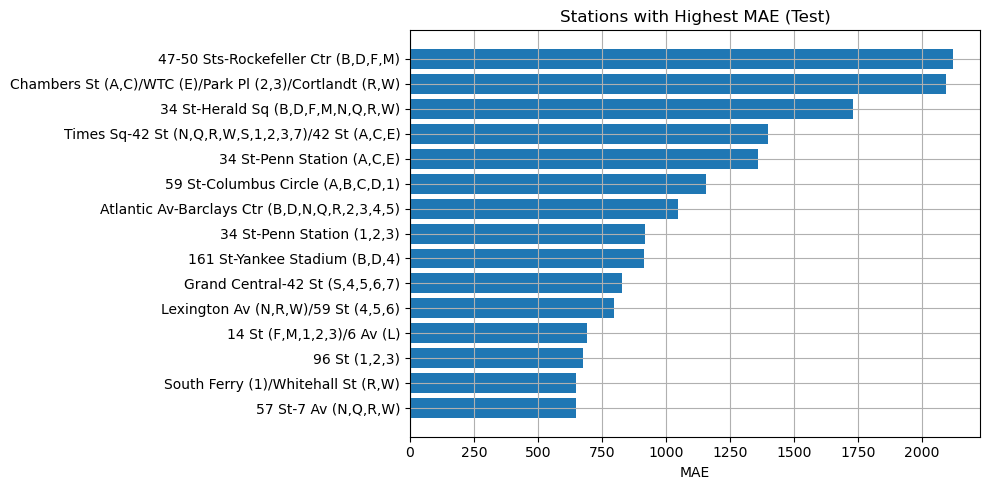

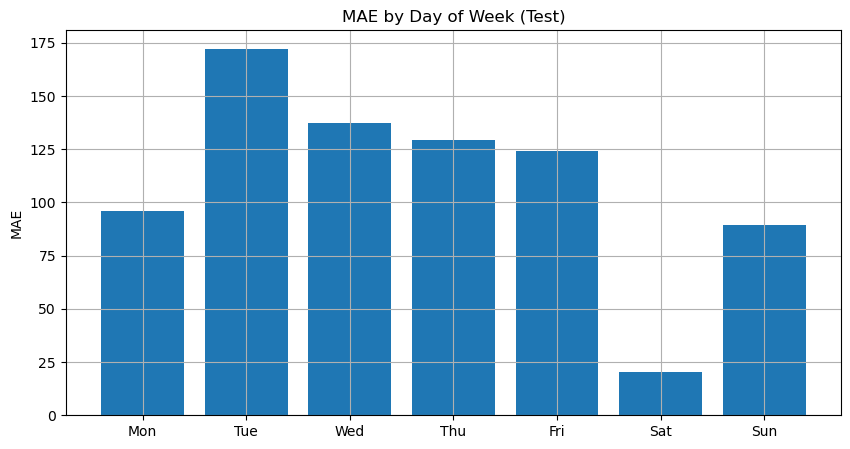

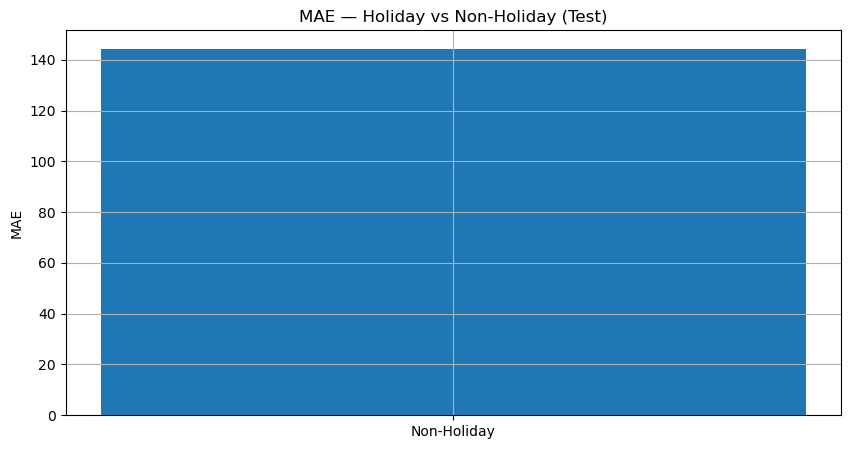

In [4]:
# By station
station_mae = j.groupby('station')['abs_error'].mean().sort_values(ascending=False)
top_underperf = station_mae.head(15)
top_best = station_mae.tail(15)

fig, ax = plt.subplots()
ax.barh(top_underperf.index[::-1], top_underperf.values[::-1])
ax.set_title('Stations with Highest MAE (Test)'); ax.set_xlabel('MAE'); plt.tight_layout(); plt.show()

# Day-of-week
dow_mae = j.groupby('dow')['abs_error'].mean().reindex([0,1,2,3,4,5,6])
fig, ax = plt.subplots()
ax.bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], dow_mae.values)
ax.set_title('MAE by Day of Week (Test)'); ax.set_ylabel('MAE'); plt.show()

# Holiday vs non-holiday
if 'is_holiday' in j.columns:
    hol_mae = j.groupby('is_holiday')['abs_error'].mean().reindex([0,1]).fillna(np.nan)
    fig, ax = plt.subplots()
    ax.bar(['Non-Holiday','Holiday'], hol_mae.values)
    ax.set_title('MAE — Holiday vs Non-Holiday (Test)'); ax.set_ylabel('MAE'); plt.show()
else:
    print("Column 'is_holiday' missing; skipping holiday slice.")

## 5) Optional: Rolling Backtest (Temporal Stability)

Rolling backtest (model class stability):


,fold,MAE,RMSE,R2
0,1,1133.110024,2736.362888,0.786412
1,2,447.729183,1221.660372,0.879747
2,3,644.415667,2610.151375,0.777599
3,4,548.276187,2896.019459,0.758508


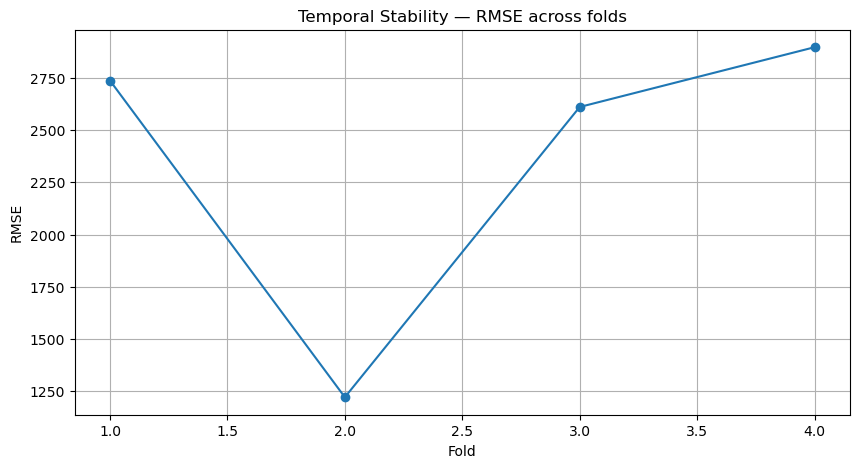

In [5]:
# Lightweight backtest to estimate stability across time folds using the final model class
# Recreate feature pipeline quickly to generate X/y (same as 02, but simplified here)
df = sd.sort_values(['station','date']).copy()
if 'dow' not in df.columns: df['dow'] = df['date'].dt.weekday
if 'is_weekend' not in df.columns: df['is_weekend'] = df['dow'].isin([5,6]).astype(int)
if 'is_holiday' not in df.columns: df['is_holiday'] = 0

grp = df.groupby('station', group_keys=False)
df['lag1'] = grp['ridership'].shift(1)
df['lag7'] = grp['ridership'].shift(7)
df['roll7_mean'] = grp['ridership'].rolling(7, min_periods=3).mean().reset_index(level=0, drop=True)
df['roll28_mean'] = grp['ridership'].rolling(28, min_periods=7).mean().reset_index(level=0, drop=True)
df = df.dropna(subset=['ridership','lag1','lag7','roll7_mean','roll28_mean']).copy()
top_stations = df['station'].value_counts().head(100).index
df['station_lumped'] = np.where(df['station'].isin(top_stations), df['station'], 'OTHER')

num_features = ['lag1','lag7','roll7_mean','roll28_mean']
cat_features = ['station_lumped','dow','is_weekend','is_holiday']
X = df[num_features + cat_features]; y = df['ridership']

# We don't need to refit grid searches here; just assess final model on folds
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)
fold_metrics = []
for i, (tr, te) in enumerate(tscv.split(X)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    # clone model to avoid leakage of fitted state
    import sklearn.base as skbase
    m = skbase.clone(final_model)
    m.fit(X_tr, y_tr)
    preds = m.predict(X_te)
    fold_metrics.append({'fold': i+1, 'MAE': np.mean(np.abs(y_te-preds)),
                         'RMSE': np.sqrt(np.mean((y_te-preds)**2)),
                         'R2': 1 - np.sum((y_te-preds)**2) / np.sum((y_te-y_te.mean())**2)})
fold_df = pd.DataFrame(fold_metrics)
print('Rolling backtest (model class stability):')
display(fold_df)
fig, ax = plt.subplots()
ax.plot(fold_df['fold'], fold_df['RMSE'], marker='o')
ax.set_title('Temporal Stability — RMSE across folds'); ax.set_xlabel('Fold'); ax.set_ylabel('RMSE'); plt.show()

## 6) Business KPIs & Exports

In [6]:
# KPI table
kpi = pd.DataFrame([overall])
kpi['model'] = model_name
kpi = kpi[['model','MAE','RMSE','R2']]
print('KPI (overall test):'); display(kpi)

# Exports
Path(DATA_PROCESSED).mkdir(parents=True, exist_ok=True)
kpi_path = f'{DATA_PROCESSED}/kpi_overall_test.csv'; kpi.to_csv(kpi_path, index=False)
station_mae_path = f'{DATA_PROCESSED}/station_mae_test.csv'; station_mae.to_csv(station_mae_path, header=['MAE'])
dow_mae_path = f'{DATA_PROCESSED}/dow_mae_test.csv'; pd.DataFrame({'dow':[0,1,2,3,4,5,6], 'MAE':dow_mae.values}).to_csv(dow_mae_path, index=False)

if 'hol_mae' in locals():
    hol_mae_path = f'{DATA_PROCESSED}/holiday_mae_test.csv'
    pd.DataFrame({'is_holiday':[0,1], 'MAE':hol_mae.values}).to_csv(hol_mae_path, index=False)
else:
    hol_mae_path = None

print('Saved:'); print('  KPI ->', kpi_path); print('  Station MAE ->', station_mae_path); print('  DOW MAE ->', dow_mae_path); print('  Holiday MAE ->', hol_mae_path)

KPI (overall test):


,model,MAE,RMSE,R2
0,RandomForest,144.393138,390.164961,0.250696


Saved:
  KPI -> ../data/processed/kpi_overall_test.csv
  Station MAE -> ../data/processed/station_mae_test.csv
  DOW MAE -> ../data/processed/dow_mae_test.csv
  Holiday MAE -> ../data/processed/holiday_mae_test.csv


## Notes
- Overall MAE/RMSE/R² on the held‑out test set quantify performance. 2-fold is most accurate, while overall model is volatile. The spike in volatility must be caused by other factors not represeented in the data. This could be things such as weather and events.
